In [29]:
CUDA_LAUNCH_BLOCKING=1

In [30]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings
import copy
#
import os
import torch
import numpy as np


class Graph:
    """The Graph to model the skeletons extracted by the Alpha-Pose.
    Args:
        - strategy: (string) must be one of the follow candidates
            - uniform: Uniform Labeling,
            - distance: Distance Partitioning,
            - spatial: Spatial Configuration,
        For more information, please refer to the section 'Partition Strategies'
            in our paper (https://arxiv.org/abs/1801.07455).
        - layout: (string) must be one of the follow candidates
            - coco_cut: Is COCO format but cut 4 joints (L-R ears, L-R eyes) out.
        - max_hop: (int) the maximal distance between two connected nodes.
        - dilation: (int) controls the spacing between the kernel points.
    """
    def __init__(self,
                 layout='coco_cut',
                 strategy='uniform',
                 max_hop=1,
                 dilation=1):
        self.max_hop = max_hop
        self.dilation = dilation

        self.get_edge(layout)
        self.hop_dis = get_hop_distance(self.num_node, self.edge, max_hop)
        self.get_adjacency(strategy)

    def get_edge(self, layout):
        if layout == 'coco_cut':
            self.num_node = 14
            self_link = [(i, i) for i in range(self.num_node)]
            neighbor_link = [(6, 4), (4, 2), (2, 13), (13, 1), (5, 3), (3, 1), (12, 10),
                             (10, 8), (8, 2), (11, 9), (9, 7), (7, 1), (13, 0)]
            self.edge = self_link + neighbor_link
            self.center = 13
        else:
            raise ValueError('This layout is not supported!')

    def get_adjacency(self, strategy):
        valid_hop = range(0, self.max_hop + 1, self.dilation)
        adjacency = np.zeros((self.num_node, self.num_node))
        for hop in valid_hop:
            adjacency[self.hop_dis == hop] = 1
        normalize_adjacency = normalize_digraph(adjacency)

        if strategy == 'uniform':
            A = np.zeros((1, self.num_node, self.num_node))
            A[0] = normalize_adjacency
            self.A = A
        elif strategy == 'distance':
            A = np.zeros((len(valid_hop), self.num_node, self.num_node))
            for i, hop in enumerate(valid_hop):
                A[i][self.hop_dis == hop] = normalize_adjacency[self.hop_dis ==
                                                                hop]
            self.A = A
        elif strategy == 'spatial':
            A = []
            for hop in valid_hop:
                a_root = np.zeros((self.num_node, self.num_node))
                a_close = np.zeros((self.num_node, self.num_node))
                a_further = np.zeros((self.num_node, self.num_node))
                for i in range(self.num_node):
                    for j in range(self.num_node):
                        if self.hop_dis[j, i] == hop:
                            if self.hop_dis[j, self.center] == self.hop_dis[i, self.center]:
                                a_root[j, i] = normalize_adjacency[j, i]
                            elif self.hop_dis[j, self.center] > self.hop_dis[i, self.center]:
                                a_close[j, i] = normalize_adjacency[j, i]
                            else:
                                a_further[j, i] = normalize_adjacency[j, i]
                if hop == 0:
                    A.append(a_root)
                else:
                    A.append(a_root + a_close)
                    A.append(a_further)
            A = np.stack(A)
            self.A = A
            #self.A = np.swapaxes(np.swapaxes(A, 0, 1), 1, 2)
        else:
            raise ValueError("This strategy is not supported!")


def get_hop_distance(num_node, edge, max_hop=1):
    A = np.zeros((num_node, num_node))
    for i, j in edge:
        A[j, i] = 1
        A[i, j] = 1

    # compute hop steps
    hop_dis = np.zeros((num_node, num_node)) + np.inf
    transfer_mat = [np.linalg.matrix_power(A, d) for d in range(max_hop + 1)]
    arrive_mat = (np.stack(transfer_mat) > 0)
    for d in range(max_hop, -1, -1):
        hop_dis[arrive_mat[d]] = d
    return hop_dis


def normalize_digraph(A):
    Dl = np.sum(A, 0)
    num_node = A.shape[0]
    Dn = np.zeros((num_node, num_node))
    for i in range(num_node):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i]**(-1)
    AD = np.dot(A, Dn)
    return AD


def normalize_undigraph(A):
    Dl = np.sum(A, 0)
    num_node = A.shape[0]
    Dn = np.zeros((num_node, num_node))
    for i in range(num_node):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i]**(-0.5)
    DAD = np.dot(np.dot(Dn, A), Dn)
    return DAD

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GraphConvolution(nn.Module):
    """The basic module for applying a graph convolution.
    Args:
        - in_channel: (int) Number of channels in the input sequence data.
        - out_channels: (int) Number of channels produced by the convolution.
        - kernel_size: (int) Size of the graph convolving kernel.
        - t_kernel_size: (int) Size of the temporal convolving kernel.
        - t_stride: (int, optional) Stride of the temporal convolution. Default: 1
        - t_padding: (int, optional) Temporal zero-padding added to both sides of
            the input. Default: 0
        - t_dilation: (int, optional) Spacing between temporal kernel elements. Default: 1
        - bias: (bool, optional) If `True`, adds a learnable bias to the output.
            Default: `True`
    Shape:
        - Inputs x: Graph sequence in :math:`(N, in_channels, T_{in}, V)`,
                 A: Graph adjacency matrix in :math:`(K, V, V)`,
        - Output: Graph sequence out in :math:`(N, out_channels, T_{out}, V)`

            where
                :math:`N` is a batch size,
                :math:`K` is the spatial kernel size, as :math:`K == kernel_size[1]`,
                :math:`T_{in}/T_{out}` is a length of input/output sequence,
                :math:`V` is the number of graph nodes.

    """
    def __init__(self, in_channels, out_channels, kernel_size,
                 t_kernel_size=1,
                 t_stride=1,
                 t_padding=0,
                 t_dilation=1,
                 bias=True):
        super().__init__()

        self.kernel_size = kernel_size
        self.conv = nn.Conv2d(in_channels,
                              out_channels * kernel_size,
                              kernel_size=(t_kernel_size, 1),
                              padding=(t_padding, 0),
                              stride=(t_stride, 1),
                              dilation=(t_dilation, 1),
                              bias=bias)

    def forward(self, x, A):
        x = self.conv(x)
        n, kc, t, v = x.size()
        x = x.view(n, self.kernel_size, kc//self.kernel_size, t, v)
        x = torch.einsum('nkctv,kvw->nctw', (x, A))

        return x.contiguous()
###########################################################
class Channel_Attention(nn.Module):
    def __init__(self,out_channels):
        super().__init__()
        
        self.atten = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Conv2d(out_channels,int(out_channels/4),1),
            nn.BatchNorm2d(int(out_channels/4)),
            nn.ReLU(),
            nn.Conv2d(int(out_channels/4),out_channels,1),
            nn.Sigmoid(),
        )
    def forward(self,x):
        
        atten = self.atten(x)
        # print(x.shape,atten.shape)
        x = x*atten
        
        return x
    

###########################################################

class st_gcn(nn.Module):
    """Applies a spatial temporal graph convolution over an input graph sequence.
    Args:
        - in_channels: (int) Number of channels in the input sequence data.
        - out_channels: (int) Number of channels produced by the convolution.
        - kernel_size: (tuple) Size of the temporal convolving kernel and
            graph convolving kernel.
        - stride: (int, optional) Stride of the temporal convolution. Default: 1
        - dropout: (int, optional) Dropout rate of the final output. Default: 0
        - residual: (bool, optional) If `True`, applies a residual mechanism.
            Default: `True`
    Shape:
        - Inputs x: Graph sequence in :math: `(N, in_channels, T_{in}, V)`,
                 A: Graph Adjecency matrix in :math: `(K, V, V)`,
        - Output: Graph sequence out in :math: `(N, out_channels, T_{out}, V)`
            where
                :math:`N` is a batch size,
                :math:`K` is the spatial kernel size, as :math:`K == kernel_size[1]`,
                :math:`T_{in}/T_{out}` is a length of input/output sequence,
                :math:`V` is the number of graph nodes.
    """
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1,
                 dropout=0,
                 residual=True):
        super().__init__()
        assert len(kernel_size) == 2
        assert kernel_size[0] % 2 == 1
        #print(kernel_size)(9, 3)
        padding = ((kernel_size[0] - 1) // 2, 0)
        #print(padding)(4, 0)

        self.gcn = GraphConvolution(in_channels, out_channels, kernel_size[1])
        self.tcn = nn.Sequential(nn.BatchNorm2d(out_channels),
                                 nn.ReLU(inplace=False),
                                 nn.Conv2d(out_channels,
                                           out_channels,
                                           (kernel_size[0], 1),
                                           (stride, 1),
                                           padding),
                                 nn.BatchNorm2d(out_channels),
                                 nn.Dropout(dropout, inplace=True),
                                 )

        if not residual:
            self.residual = lambda x: 0
        elif (in_channels == out_channels) and (stride == 1):
            self.residual = lambda x: x
        else:
            self.residual = nn.Sequential(nn.Conv2d(in_channels,
                                                    out_channels,
                                                    kernel_size=1,
                                                    stride=(stride, 1)),
                                          nn.BatchNorm2d(out_channels)
                                          )
        self.relu = nn.ReLU(inplace=False)
        self.channel_attention_module = Channel_Attention(out_channels) 
        
    def forward(self, x, A):
        res = self.residual(x)
        # print(res)
        x = self.gcn(x, A)
        #print("x_in:",x.size())
        # x = self.tcn(x) + res
        #print("x_out:",x.size())
        x = self.tcn(x)
        x = self.channel_attention_module(x) + res
        
        return self.relu(x)


class StreamSpatialTemporalGraph(nn.Module):
    """Spatial temporal graph convolutional networks.
    Args:
        - in_channels: (int) Number of input channels.
        - graph_args: (dict) Args map of `Actionsrecognition.Utils.Graph` Class.
        - num_class: (int) Number of class outputs. If `None` return pooling features of
            the last st-gcn layer instead.
        - edge_importance_weighting: (bool) If `True`, adds a learnable importance
            weighting to the edges of the graph.
        - **kwargs: (optional) Other parameters for graph convolution units.
    Shape:
        - Input: :math:`(N, in_channels, T_{in}, V_{in})`
        - Output: :math:`(N, num_class)` where
            :math:`N` is a batch size,
            :math:`T_{in}` is a length of input sequence,
            :math:`V_{in}` is the number of graph nodes,
        or If num_class is `None`: `(N, out_channels)`
            :math:`out_channels` is number of out_channels of the last layer.
    """
    def __init__(self, in_channels, graph_args, num_class=None,
                 edge_importance_weighting=True, **kwargs):
        super().__init__()
        # Load graph.
        graph = Graph(**graph_args)
        A = torch.tensor(graph.A, dtype=torch.float32, requires_grad=False)
        self.register_buffer('A', A)

        # Networks.
        spatial_kernel_size = A.size(0)
        temporal_kernel_size = 9
        kernel_size = (temporal_kernel_size, spatial_kernel_size)
        kwargs0 = {k: v for k, v in kwargs.items() if k != 'dropout'}

        self.data_bn = nn.BatchNorm1d(in_channels * A.size(1))
        self.st_gcn_networks = nn.ModuleList((
            st_gcn(in_channels, 64, kernel_size, 1, residual=False, **kwargs0),
            
            st_gcn(64, 64, kernel_size, 1, **kwargs),
            st_gcn(64, 64, kernel_size, 1, **kwargs),
            # st_gcn(64, 64, kernel_size, 1, **kwargs),
            st_gcn(64, 128, kernel_size, 2, **kwargs),
            st_gcn(128, 128, kernel_size, 1, **kwargs),
            # st_gcn(128, 128, kernel_size, 1, **kwargs),
            st_gcn(128, 256, kernel_size, 2, **kwargs),
            st_gcn(256, 256, kernel_size, 1, **kwargs),
            # st_gcn(256, 256, kernel_size, 1, **kwargs)
        ))

        # initialize parameters for edge importance weighting.
        if edge_importance_weighting:
            self.edge_importance = nn.ParameterList([
                nn.Parameter(torch.ones(A.size()))
                for i in self.st_gcn_networks
            ])
        else:
            self.edge_importance = [1] * len(self.st_gcn_networks)

        if num_class is not None:
            self.cls = nn.Conv2d(256, num_class, kernel_size=1)
        else:
            self.cls = lambda x: x

    def forward(self, x):
        # data normalization.
        N, C, T, V = x.size()
        x = x.permute(0, 3, 1, 2).contiguous()  # (N, V, C, T)
        x = x.view(N, V * C, T)
        x = self.data_bn(x)
        x = x.view(N, V, C, T)
        x = x.permute(0, 2, 3, 1).contiguous()
        x = x.view(N, C, T, V)

        # forward.
        for gcn, importance in zip(self.st_gcn_networks, self.edge_importance):
            x = gcn(x, self.A * importance)
        #(B: 32,256, 6 or 7, node: 14, )
        x = F.avg_pool2d(x, x.size()[2:])
        x = self.cls(x)
        x = x.view(x.size(0), -1)

        return x


class TwoStreamSpatialTemporalGraph(nn.Module):
    """Two inputs spatial temporal graph convolutional networks.
    Args:
        - graph_args: (dict) Args map of `Actionsrecognition.Utils.Graph` Class.
        - num_class: (int) Number of class outputs.
        - edge_importance_weighting: (bool) If `True`, adds a learnable importance
            weighting to the edges of the graph.
        - **kwargs: (optional) Other parameters for graph convolution units.
    Shape:
        - Input: :tuple of math:`((N, 3, T, V), (N, 2, T, V))`
        for points and motions stream where.
            :math:`N` is a batch size,
            :math:`in_channels` is data channels (3 is (x, y, score)), (2 is (mot_x, mot_y))
            :math:`T` is a length of input sequence,
            :math:`V` is the number of graph nodes,
        - Output: :math:`(N, num_class)`
    """
    def __init__(self, graph_args, num_class, edge_importance_weighting=True,
                 **kwargs):
        super().__init__()
        self.pts_stream = StreamSpatialTemporalGraph(3, graph_args, None,
                                                     edge_importance_weighting,
                                                     **kwargs)#3 is x,y,z
        self.mot_stream = StreamSpatialTemporalGraph(2, graph_args, None,
                                                     edge_importance_weighting,
                                                     **kwargs)#2 is x,y

        self.fcn = nn.Linear(256 * 2, num_class)
        # print("errr")
        
        
        # self.attention1=nn.Sequential(
        #     nn.Linear(256 * 2, 128),
        #     nn.BatchNorm1d(128),
        #     nn.LeakyReLU(inplace=False),
        #     nn.Linear(128, 256 * 2),
        #     nn.BatchNorm1d(256 * 2),
        #     nn.Sigmoid(),
        # )
        
        # self.attention2=nn.Sequential(
        #     nn.Linear(256 * 2, 128),
        #     nn.BatchNorm1d(128),
        #     nn.ReLU(inplace=False),
        #     nn.Linear(128, 256 * 2),
        #     nn.BatchNorm1d(256 * 2),
        #     nn.Sigmoid(),
        # )
        
        # self.attention3=nn.Sequential(
        #     nn.Linear(256 * 2, 64),
        #     nn.BatchNorm1d(64),
        #     nn.ReLU(inplace=False),
        #     nn.Linear(64, 256 * 2),
        #     nn.BatchNorm1d(256 * 2),
        #     nn.Sigmoid(),
        # )
        
        # self.attention4=nn.Sequential(
        #     nn.Linear(256 * 2, 64),
        #     nn.BatchNorm1d(64),
        #     nn.ReLU(inplace=False),
        #     nn.Linear(64, 64),
        #     nn.BatchNorm1d(64),
        #     nn.ReLU(inplace=False),
        #     nn.Linear(64, 256 * 2),
        #     nn.BatchNorm1d(256 * 2),
        #     nn.Sigmoid(),
        # )
        
        # self.attention5=nn.Sequential(
        #     nn.Linear(256 * 2, 128),
        #     nn.BatchNorm1d(128),
        #     nn.GELU(),
        #     nn.Linear(128, 256 * 2),
        #     nn.BatchNorm1d(256 * 2),
        #     nn.Sigmoid(),
        # )
        
    def forward(self, inputs):
        out1 = self.pts_stream(inputs[0])
        out2 = self.mot_stream(inputs[1])
        
        #print(out1.size())torch.Size([32, 256])
        #print(out2.size())torch.Size([32, 256])
        concat = torch.cat([out1, out2], dim=-1)
    
        
        # concat =  self.attention1(concat)
        # concat =  self.attention2(concat)
        # concat =  self.attention3(concat)
        # concat =  self.attention4(concat)
        # concat =  self.attention5(concat)
        
        out = self.fcn(concat)
        #print(out.size())
        # return torch.sigmoid(out)
        return F.softmax(out,dim=-1)

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as f

####1DCNN(時系列により)######
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(4, 16, kernel_size=5, padding=2), #batch,チャンネル、シーケンス 入力チャンネル=30, 出力チャンネル=16
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(2))
        self.layer2 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2))
        self.fc = nn.Linear(32*7, 32)  

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)#torch.Size([32, 32, 7])
        # x = x.view(x.size(0), -1)  # Flatten
        # x = self.fc(x)torch.Size([32, 32])
        # print(x.size())
        return x
####LSTM#####
class ChannelAttention(nn.Module):
    def __init__(self, input_size, reduce_rate = 1/8):
        super(ChannelAttention,self).__init__()
        
        self.attention = nn.Sequential(
            nn.Linear(input_size, int(input_size*reduce_rate)),
            nn.ReLU(),
            nn.Linear(int(input_size*reduce_rate), input_size),
            nn.Sigmoid(),
        )
        
    def forward(self,x):
        weight = self.attention(x)
        x = torch.einsum('bc,bc -> bc',(x,weight))
        return x
    
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_prob, num_classes = 1, feature = "last"):
        super(BiLSTM,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        # Bidirectional LSTM layer
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True,dropout=dropout_prob)
        
        self.batchnorm = nn.BatchNorm1d(hidden_size*2)
        self.channelattention = ChannelAttention(hidden_size*2)
        
        self.feature = feature
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_size*2,num_classes)
        )
        
    def forward(self, x):
        # x = self.attention(x)
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # Multiply by 2 for bidirectional
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm1(x, (h0, c0))
        
        
        # out = self.meanovertime(out)
        if self.feature=="last":
            out = out[:, -1, :]
        else:
            out = torch.mean(out,axis=1,keepdim=False)
        out = self.batchnorm(out)
        out = self.channelattention(out)
        out = self.fc(out)
        return out
    
class CNN_BiLSTM(nn.Module):
    def __init__(self, hidden_size, num_layers, dropout_prob, num_classes=1, feature="last"):
        super(CNN_BiLSTM, self).__init__()
        self.cnn = CNN1D()
        self.bilstm = BiLSTM(input_size=32,hidden_size=64,num_layers=1,dropout_prob=0.3,num_classes=2,feature="mean")
    
    def forward(self, x):
        x = x.permute(0,2,1)
        cnn_out = self.cnn(x)
        # print(cnn_out)
        # cnn_out = cnn_out.unsqueeze(1)# LSTMに渡すために次元を調整 (batch, seq_len, feature)torch.Size([32, 1, 32])
        # print(cnn_out.size())
        cnn_out = cnn_out.permute(0,2,1)
        lstm_out = self.bilstm(cnn_out)
        return lstm_out
    
    
# model = BiLSTM(input_size=4,hidden_size=125,num_layers=1,dropout_prob=0.3,num_classes=2,feature="mean")

In [32]:
# inp=torch.randn(8,2,21,14)
# inp=inp.cuda()

# #print(a[1].shape)
# a=model(inp)
# print(a.shape)

In [33]:
import torch
from torch.utils.data import Dataset

class Skeleton_Sensor_Dataset(Dataset):
    def __init__(self,skeleton_sensor_data,label):
        self.skeleton_sensor_data = skeleton_sensor_data
        self.label = label
        
    def __len__(self):
        return len(self.skeleton_sensor_data)
    
    def __getitem__(self,idx):
        skeleton,sensor = self.skeleton_sensor_data[idx]
        label = self.label[idx]
        
        # print(f"DEBUG {type(skeleton.dtype)}, {type(sensor.dtype)} {type(label.dtype)} ")
        
        if not isinstance(skeleton,torch.Tensor):
            skeleton = torch.tensor(skeleton,dtype=torch.float32)
            
        if not isinstance(sensor,torch.Tensor):
            sensor = torch.tensor(sensor,dtype=torch.float32)
        
        if not isinstance(label,torch.Tensor):
            label = torch.tensor(label,dtype=torch.float32)
            
        skeleton = skeleton.permute(2,0,1)
        return skeleton,sensor,label
    
class Skeleton_Sensor_Dataset_v2(Dataset):
    def __init__(self,skeleton_sensor_data,label):
        self.skeleton_sensor_data = skeleton_sensor_data
        self.label = label
        
    def __len__(self):
        return len(self.skeleton_sensor_data)
    
    def __getitem__(self,idx):
        skeleton,sensor = self.skeleton_sensor_data[idx]
        label = self.label[idx]
        
        # print(f"DEBUG {type(skeleton.dtype)}, {type(sensor.dtype)} {type(label.dtype)} ")
        
        if not isinstance(skeleton,torch.Tensor):
            skeleton = torch.tensor(skeleton,dtype=torch.float32)
            
        if not isinstance(sensor,torch.Tensor):
            sensor = torch.tensor(sensor,dtype=torch.float32)
        
        if not isinstance(label,torch.Tensor):
            label = torch.tensor(label,dtype=torch.float32)
            
        skeleton = skeleton.permute(2,0,1) # skeleton [num_sample, (time, vertex, xyz)] -> [num_sample, (xyz, time, vertex)]
        return skeleton,sensor,label
    
def custom_collate_fn(batch):
    skeletons = [item[0] for item in batch]
    sensors = [item[1] for item in batch]
    labels = [item[2] for item in batch]

    skeletons = torch.stack(skeletons)
    sensors = torch.stack(sensors)
    labels = torch.stack(labels)  # 例: ラベルが整数である場合

    return skeletons, sensors, labels

In [34]:
def load_dataset(data_files, batch_size, split_size=0.2):#0.2
    """Load data files into torch DataLoader with/without spliting train-test.
    """
    features,sensors, labels = [], [], []
    for fil in data_files:
        # print(fil)
        with open(fil, 'rb') as f:
            _ ,fts,sr,lbs = pickle.load(f)
            videos += vid
            features.append(fts)
            sensors.append(sr)
            labels.append(lbs)
        del fts, lbs,sr
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    sensors = np.concatenate(sensors, axis=0)
    # print(features.shape,labels.shape)
    # print(f"DEBUG {features.shape},{sensors.shape},{labels.shape}")
    labels = labels.astype(np.float32)
    
    samples = []
    for feature,sensor in zip(features,sensors):
        samples += [(feature,sensor)]
    # samples = np.array(samples,dtype=object)
    
    if split_size > 0:
        x_train, x_valid, y_train, y_valid = train_test_split(samples, labels, test_size=split_size,random_state=9)
        
        # train_set = data.TensorDataset(torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2),
        #                                torch.tensor(y_train, dtype=torch.float32))
        # valid_set = data.TensorDataset(torch.tensor(x_valid, dtype=torch.float32).permute(0, 3, 1, 2),
        #                                torch.tensor(y_valid, dtype=torch.float32))
        train_set = Skeleton_Sensor_Dataset(x_train,y_train)
        valid_set = Skeleton_Sensor_Dataset(x_valid,y_valid)
        train_loader = data.DataLoader(train_set, batch_size, shuffle=True)
        valid_loader = data.DataLoader(valid_set, batch_size)
    else:
        # train_set = data.TensorDataset(torch.tensor(features, dtype=torch.float32).permute(0, 3, 1, 2),
        #                                torch.tensor(labels, dtype=torch.float32))
        train_set = Skeleton_Sensor_Dataset(features,labels)
        train_loader = data.DataLoader(train_set, batch_size, shuffle=True)
        valid_loader = None
    return train_loader, valid_loader


def load_dataset_v2(data_files, batch_size, split_size=0.2):#0.2
    """Load data files into torch DataLoader with/without spliting train-test.
    """
    videos = []
    features,sensors, labels = [], [], []
    for fil in data_files:
        # print(fil)
        with open(fil, 'rb') as f:
            vid ,fts,sr, lbs = pickle.load(f)
            videos += vid
            features.append(fts)
            sensors.append(sr)
            labels.append(lbs)
        del fts, lbs,sr
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    sensors = np.concatenate(sensors, axis=0)
    # print(features.shape,labels.shape)
    # print(f"DEBUG {features.shape},{sensors.shape},{labels.shape}")
    labels = labels.astype(np.float32) # dtype : object -> float32
    
    if split_size > 0:
        unique_video_names = np.unique(videos)
        train_videos, test_videos= train_test_split(unique_video_names,test_size=split_size,random_state=9)

        train_samples,valid_samples = [],[]
        train_label,valid_label = [],[]
        for video,feature,sensor,label in zip(videos,features,sensors,labels):
            if video in train_videos:
                train_samples += [(feature,sensor)]
                train_label += [label]
            else:
                valid_samples += [(feature,sensor)]
                valid_label += [label]
        
        train_set = Skeleton_Sensor_Dataset(train_samples,train_label)
        valid_set = Skeleton_Sensor_Dataset(valid_samples,valid_label)
        train_loader = data.DataLoader(train_set, batch_size, shuffle=True,)
        valid_loader = data.DataLoader(valid_set, batch_size)
    
    else:
        samples = []
        for feature,sensor in zip(features,sensors):
            samples += [(feature,sensor)]
        train_set = Skeleton_Sensor_Dataset(samples,labels)
        train_loader = data.DataLoader(train_set, batch_size, shuffle=True)
        valid_loader = None
    return train_loader, valid_loader

using cuda device
number of params: 65154
Epoch 0/99


valid: 100%|██████████| 8/8 [00:00<00:00, 473.73it/s,  loss: 0.4366, accu: 1.0000]

Summary epoch:
 - Train loss: 0.3068, accu: 0.9433
 - Valid loss: 0.3689, accu: 0.9609
0.9609375


Epoch 1/99


valid: 100%|██████████| 8/8 [00:00<00:00, 463.17it/s,  loss: 0.3913, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2661, accu: 0.9917
 - Valid loss: 0.3246, accu: 0.9648
0.96484375


Epoch 2/99


valid: 100%|██████████| 8/8 [00:00<00:00, 467.19it/s,  loss: 0.3624, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2657, accu: 0.9906
 - Valid loss: 0.3192, accu: 0.9688
0.96875


Epoch 3/99


valid: 100%|██████████| 8/8 [00:00<00:00, 475.52it/s,  loss: 0.3635, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2653, accu: 0.9917
 - Valid loss: 0.3174, accu: 0.9688
0.96875


Epoch 4/99


valid: 100%|██████████| 8/8 [00:00<00:00, 478.81it/s,  loss: 0.3637, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2647, accu: 0.9927
 - Valid loss: 0.3134, accu: 0.9766
0.9765625


Epoch 5/99


valid: 100%|██████████| 8/8 [00:00<00:00, 486.18it/s,  loss: 0.3610, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2643, accu: 0.9927
 - Valid loss: 0.3180, accu: 0.9648
0.9765625


Epoch 6/99


valid: 100%|██████████| 8/8 [00:00<00:00, 483.52it/s,  loss: 0.3613, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2643, accu: 0.9938
 - Valid loss: 0.3150, accu: 0.9805
0.98046875


Epoch 7/99


valid: 100%|██████████| 8/8 [00:00<00:00, 480.04it/s,  loss: 0.3612, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2645, accu: 0.9927
 - Valid loss: 0.3158, accu: 0.9688
0.98046875


Epoch 8/99


valid: 100%|██████████| 8/8 [00:00<00:00, 483.28it/s,  loss: 0.3618, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2638, accu: 0.9948
 - Valid loss: 0.3124, accu: 0.9688
0.98046875


Epoch 9/99


valid: 100%|██████████| 8/8 [00:00<00:00, 482.36it/s,  loss: 0.3614, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2635, accu: 0.9938
 - Valid loss: 0.3122, accu: 0.9727
0.98046875


Epoch 10/99


valid: 100%|██████████| 8/8 [00:00<00:00, 489.74it/s,  loss: 0.3620, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2634, accu: 0.9969
 - Valid loss: 0.3115, accu: 0.9688
0.98046875


Epoch 11/99


valid: 100%|██████████| 8/8 [00:00<00:00, 482.51it/s,  loss: 0.3638, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2633, accu: 0.9933
 - Valid loss: 0.3118, accu: 0.9766
0.98046875


Epoch 12/99


valid: 100%|██████████| 8/8 [00:00<00:00, 481.62it/s,  loss: 0.3613, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2633, accu: 0.9938
 - Valid loss: 0.3107, accu: 0.9766
0.98046875


Epoch 13/99


valid: 100%|██████████| 8/8 [00:00<00:00, 473.97it/s,  loss: 0.3669, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2631, accu: 0.9958
 - Valid loss: 0.3159, accu: 0.9648
0.98046875


Epoch 14/99


valid: 100%|██████████| 8/8 [00:00<00:00, 478.62it/s,  loss: 0.3634, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2632, accu: 0.9948
 - Valid loss: 0.3163, accu: 0.9688
0.98046875


Epoch 15/99


valid: 100%|██████████| 8/8 [00:00<00:00, 481.13it/s,  loss: 0.3612, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2630, accu: 0.9958
 - Valid loss: 0.3102, accu: 0.9805
0.98046875


Epoch 16/99


valid: 100%|██████████| 8/8 [00:00<00:00, 479.47it/s,  loss: 0.3748, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2630, accu: 0.9906
 - Valid loss: 0.3241, accu: 0.9531
0.98046875


Epoch 17/99


valid: 100%|██████████| 8/8 [00:00<00:00, 476.33it/s,  loss: 0.3614, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2629, accu: 0.9964
 - Valid loss: 0.3123, accu: 0.9727
0.98046875


Epoch 18/99


valid: 100%|██████████| 8/8 [00:00<00:00, 484.09it/s,  loss: 0.3629, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2629, accu: 0.9933
 - Valid loss: 0.3275, accu: 0.9570
0.98046875


Epoch 19/99


valid: 100%|██████████| 8/8 [00:00<00:00, 475.77it/s,  loss: 0.3627, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2628, accu: 0.9938
 - Valid loss: 0.3108, accu: 0.9727
0.98046875


Epoch 20/99


valid: 100%|██████████| 8/8 [00:00<00:00, 487.50it/s,  loss: 0.3636, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2627, accu: 0.9969
 - Valid loss: 0.3117, accu: 0.9766
0.98046875


Epoch 21/99


valid: 100%|██████████| 8/8 [00:00<00:00, 472.99it/s,  loss: 0.3630, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2628, accu: 0.9927
 - Valid loss: 0.3116, accu: 0.9766
0.98046875


Epoch 22/99


valid: 100%|██████████| 8/8 [00:00<00:00, 485.97it/s,  loss: 0.3670, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2629, accu: 0.9969
 - Valid loss: 0.3249, accu: 0.9648
0.98046875


Epoch 23/99


valid: 100%|██████████| 8/8 [00:00<00:00, 474.84it/s,  loss: 0.3646, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2629, accu: 0.9906
 - Valid loss: 0.3117, accu: 0.9727
0.98046875


Epoch 24/99


valid: 100%|██████████| 8/8 [00:00<00:00, 482.28it/s,  loss: 0.3618, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2627, accu: 0.9954
 - Valid loss: 0.3180, accu: 0.9688
0.98046875


Epoch 25/99


valid: 100%|██████████| 8/8 [00:00<00:00, 469.94it/s,  loss: 0.3655, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2630, accu: 0.9948
 - Valid loss: 0.3130, accu: 0.9688
0.98046875


Epoch 26/99


valid: 100%|██████████| 8/8 [00:00<00:00, 467.63it/s,  loss: 0.3621, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2624, accu: 0.9979
 - Valid loss: 0.3131, accu: 0.9727
0.98046875


Epoch 27/99


valid: 100%|██████████| 8/8 [00:00<00:00, 478.64it/s,  loss: 0.3617, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2627, accu: 0.9954
 - Valid loss: 0.3140, accu: 0.9688
0.98046875


Epoch 28/99


valid: 100%|██████████| 8/8 [00:00<00:00, 481.41it/s,  loss: 0.3636, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2627, accu: 0.9958
 - Valid loss: 0.3193, accu: 0.9727
0.98046875


Epoch 29/99


valid: 100%|██████████| 8/8 [00:00<00:00, 478.73it/s,  loss: 0.3640, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2624, accu: 0.9958
 - Valid loss: 0.3147, accu: 0.9727
0.98046875


Epoch 30/99


valid: 100%|██████████| 8/8 [00:00<00:00, 484.85it/s,  loss: 0.3651, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2627, accu: 0.9969
 - Valid loss: 0.3127, accu: 0.9688
0.98046875


Epoch 31/99


valid: 100%|██████████| 8/8 [00:00<00:00, 476.08it/s,  loss: 0.3641, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2626, accu: 0.9964
 - Valid loss: 0.3208, accu: 0.9883
0.98828125


Epoch 32/99


valid: 100%|██████████| 8/8 [00:00<00:00, 474.93it/s,  loss: 0.3621, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2626, accu: 0.9969
 - Valid loss: 0.3107, accu: 0.9727
0.98828125


Epoch 33/99


valid: 100%|██████████| 8/8 [00:00<00:00, 488.32it/s,  loss: 0.3635, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2626, accu: 0.9958
 - Valid loss: 0.3094, accu: 0.9844
0.98828125


Epoch 34/99


valid: 100%|██████████| 8/8 [00:00<00:00, 488.31it/s,  loss: 0.3664, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2624, accu: 0.9969
 - Valid loss: 0.3112, accu: 0.9727
0.98828125


Epoch 35/99


valid: 100%|██████████| 8/8 [00:00<00:00, 487.54it/s,  loss: 0.3657, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2622, accu: 0.9990
 - Valid loss: 0.3103, accu: 0.9805
0.98828125


Epoch 36/99


valid: 100%|██████████| 8/8 [00:00<00:00, 484.22it/s,  loss: 0.3668, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2627, accu: 0.9948
 - Valid loss: 0.3142, accu: 0.9688
0.98828125


Epoch 37/99


valid: 100%|██████████| 8/8 [00:00<00:00, 481.73it/s,  loss: 0.3699, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2625, accu: 0.9958
 - Valid loss: 0.3159, accu: 0.9648
0.98828125


Epoch 38/99


valid: 100%|██████████| 8/8 [00:00<00:00, 490.95it/s,  loss: 0.3706, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2621, accu: 0.9958
 - Valid loss: 0.3183, accu: 0.9688
0.98828125


Epoch 39/99


valid: 100%|██████████| 8/8 [00:00<00:00, 480.74it/s,  loss: 0.3696, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2626, accu: 0.9969
 - Valid loss: 0.3218, accu: 0.9531
0.98828125


Epoch 40/99


valid: 100%|██████████| 8/8 [00:00<00:00, 474.29it/s,  loss: 0.3640, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2626, accu: 0.9964
 - Valid loss: 0.3111, accu: 0.9766
0.98828125


Epoch 41/99


valid: 100%|██████████| 8/8 [00:00<00:00, 484.94it/s,  loss: 0.3631, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2625, accu: 0.9969
 - Valid loss: 0.3096, accu: 0.9883
0.98828125


Epoch 42/99


valid: 100%|██████████| 8/8 [00:00<00:00, 486.75it/s,  loss: 0.3663, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2622, accu: 0.9979
 - Valid loss: 0.3109, accu: 0.9766
0.98828125


Epoch 43/99


valid: 100%|██████████| 8/8 [00:00<00:00, 467.58it/s,  loss: 0.3658, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2624, accu: 0.9958
 - Valid loss: 0.3119, accu: 0.9805
0.98828125


Epoch 44/99


valid: 100%|██████████| 8/8 [00:00<00:00, 473.53it/s,  loss: 0.3654, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2623, accu: 0.9969
 - Valid loss: 0.3173, accu: 0.9727
0.98828125


Epoch 45/99


valid: 100%|██████████| 8/8 [00:00<00:00, 474.34it/s,  loss: 0.3673, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2623, accu: 0.9958
 - Valid loss: 0.3118, accu: 0.9766
0.98828125


Epoch 46/99


valid: 100%|██████████| 8/8 [00:00<00:00, 485.19it/s,  loss: 0.3639, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2625, accu: 0.9938
 - Valid loss: 0.3144, accu: 0.9727
0.98828125


Epoch 47/99


valid: 100%|██████████| 8/8 [00:00<00:00, 470.28it/s,  loss: 0.3659, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2621, accu: 0.9990
 - Valid loss: 0.3143, accu: 0.9766
0.98828125


Epoch 48/99


valid: 100%|██████████| 8/8 [00:00<00:00, 484.38it/s,  loss: 0.3686, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2626, accu: 0.9958
 - Valid loss: 0.3117, accu: 0.9766
0.98828125


Epoch 49/99


valid: 100%|██████████| 8/8 [00:00<00:00, 444.74it/s,  loss: 0.3642, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2624, accu: 0.9958
 - Valid loss: 0.3160, accu: 0.9766
0.98828125


Epoch 50/99


valid: 100%|██████████| 8/8 [00:00<00:00, 486.04it/s,  loss: 0.3673, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2623, accu: 0.9990
 - Valid loss: 0.3134, accu: 0.9805
0.98828125


Epoch 51/99


valid: 100%|██████████| 8/8 [00:00<00:00, 467.03it/s,  loss: 0.3691, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2624, accu: 0.9933
 - Valid loss: 0.3151, accu: 0.9688
0.98828125


Epoch 52/99


valid: 100%|██████████| 8/8 [00:00<00:00, 467.59it/s,  loss: 0.3629, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2624, accu: 0.9979
 - Valid loss: 0.3106, accu: 0.9727
0.98828125


Epoch 53/99


valid: 100%|██████████| 8/8 [00:00<00:00, 467.31it/s,  loss: 0.3662, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2624, accu: 0.9958
 - Valid loss: 0.3112, accu: 0.9727
0.98828125


Epoch 54/99


valid: 100%|██████████| 8/8 [00:00<00:00, 471.11it/s,  loss: 0.3648, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2623, accu: 0.9964
 - Valid loss: 0.3129, accu: 0.9766
0.98828125


Epoch 55/99


valid: 100%|██████████| 8/8 [00:00<00:00, 467.94it/s,  loss: 0.3687, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2622, accu: 0.9969
 - Valid loss: 0.3131, accu: 0.9727
0.98828125


Epoch 56/99


valid: 100%|██████████| 8/8 [00:00<00:00, 460.39it/s,  loss: 0.3667, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2622, accu: 0.9979
 - Valid loss: 0.3117, accu: 0.9766
0.98828125


Epoch 57/99


valid: 100%|██████████| 8/8 [00:00<00:00, 459.69it/s,  loss: 0.3626, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2622, accu: 0.9990
 - Valid loss: 0.3205, accu: 0.9492
0.98828125


Epoch 58/99


valid: 100%|██████████| 8/8 [00:00<00:00, 457.66it/s,  loss: 0.3634, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2624, accu: 0.9969
 - Valid loss: 0.3140, accu: 0.9805
0.98828125


Epoch 59/99


valid: 100%|██████████| 8/8 [00:00<00:00, 435.21it/s,  loss: 0.3674, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2621, accu: 0.9969
 - Valid loss: 0.3115, accu: 0.9805
0.98828125


Epoch 60/99


valid: 100%|██████████| 8/8 [00:00<00:00, 455.53it/s,  loss: 0.3665, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2625, accu: 0.9958
 - Valid loss: 0.3117, accu: 0.9688
0.98828125


Epoch 61/99


valid: 100%|██████████| 8/8 [00:00<00:00, 468.69it/s,  loss: 0.3700, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2623, accu: 0.9990
 - Valid loss: 0.3127, accu: 0.9805
0.98828125


Epoch 62/99


valid: 100%|██████████| 8/8 [00:00<00:00, 456.62it/s,  loss: 0.3678, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2622, accu: 0.9990
 - Valid loss: 0.3119, accu: 0.9766
0.98828125


Epoch 63/99


valid: 100%|██████████| 8/8 [00:00<00:00, 460.65it/s,  loss: 0.3680, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2620, accu: 0.9979
 - Valid loss: 0.3149, accu: 0.9766
0.98828125


Epoch 64/99


valid: 100%|██████████| 8/8 [00:00<00:00, 463.52it/s,  loss: 0.3620, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2625, accu: 0.9969
 - Valid loss: 0.3280, accu: 0.9414
0.98828125


Epoch 65/99


valid: 100%|██████████| 8/8 [00:00<00:00, 470.23it/s,  loss: 0.3666, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2624, accu: 0.9969
 - Valid loss: 0.3119, accu: 0.9805
0.98828125


Epoch 66/99


valid: 100%|██████████| 8/8 [00:00<00:00, 470.31it/s,  loss: 0.3654, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2623, accu: 0.9990
 - Valid loss: 0.3105, accu: 0.9766
0.98828125


Epoch 67/99


valid: 100%|██████████| 8/8 [00:00<00:00, 475.69it/s,  loss: 0.3650, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2624, accu: 0.9979
 - Valid loss: 0.3112, accu: 0.9766
0.98828125


Epoch 68/99


valid: 100%|██████████| 8/8 [00:00<00:00, 434.60it/s,  loss: 0.3685, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2621, accu: 0.9969
 - Valid loss: 0.3130, accu: 0.9805
0.98828125


Epoch 69/99


valid: 100%|██████████| 8/8 [00:00<00:00, 469.26it/s,  loss: 0.3653, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2623, accu: 0.9969
 - Valid loss: 0.3106, accu: 0.9805
0.98828125


Epoch 70/99


valid: 100%|██████████| 8/8 [00:00<00:00, 463.72it/s,  loss: 0.3663, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2620, accu: 0.9990
 - Valid loss: 0.3138, accu: 0.9727
0.98828125


Epoch 71/99


valid: 100%|██████████| 8/8 [00:00<00:00, 466.89it/s,  loss: 0.3659, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2623, accu: 0.9979
 - Valid loss: 0.3147, accu: 0.9805
0.98828125


Epoch 72/99


valid: 100%|██████████| 8/8 [00:00<00:00, 464.96it/s,  loss: 0.3692, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2623, accu: 0.9979
 - Valid loss: 0.3113, accu: 0.9766
0.98828125


Epoch 73/99


valid: 100%|██████████| 8/8 [00:00<00:00, 462.81it/s,  loss: 0.3704, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2621, accu: 0.9990
 - Valid loss: 0.3113, accu: 0.9766
0.98828125


Epoch 74/99


valid: 100%|██████████| 8/8 [00:00<00:00, 475.51it/s,  loss: 0.3663, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2622, accu: 1.0000
 - Valid loss: 0.3127, accu: 0.9805
0.98828125


Epoch 75/99


valid: 100%|██████████| 8/8 [00:00<00:00, 478.45it/s,  loss: 0.3661, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2622, accu: 0.9990
 - Valid loss: 0.3157, accu: 0.9766
0.98828125


Epoch 76/99


valid: 100%|██████████| 8/8 [00:00<00:00, 475.16it/s,  loss: 0.3656, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2620, accu: 0.9958
 - Valid loss: 0.3103, accu: 0.9805
0.98828125


Epoch 77/99


valid: 100%|██████████| 8/8 [00:00<00:00, 464.65it/s,  loss: 0.3731, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2621, accu: 0.9979
 - Valid loss: 0.3137, accu: 0.9727
0.98828125


Epoch 78/99


valid: 100%|██████████| 8/8 [00:00<00:00, 465.67it/s,  loss: 0.3685, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2621, accu: 0.9979
 - Valid loss: 0.3131, accu: 0.9727
0.98828125


Epoch 79/99


valid: 100%|██████████| 8/8 [00:00<00:00, 489.14it/s,  loss: 0.3662, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2622, accu: 0.9948
 - Valid loss: 0.3395, accu: 0.9141
0.98828125


Epoch 80/99


valid: 100%|██████████| 8/8 [00:00<00:00, 479.50it/s,  loss: 0.3670, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2622, accu: 0.9969
 - Valid loss: 0.3430, accu: 0.9219
0.98828125


Epoch 81/99


valid: 100%|██████████| 8/8 [00:00<00:00, 474.19it/s,  loss: 0.3704, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2620, accu: 0.9958
 - Valid loss: 0.3287, accu: 0.9453
0.98828125


Epoch 82/99


valid: 100%|██████████| 8/8 [00:00<00:00, 396.82it/s,  loss: 0.3620, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2622, accu: 1.0000
 - Valid loss: 0.3108, accu: 0.9727
0.98828125


Epoch 83/99


valid: 100%|██████████| 8/8 [00:00<00:00, 474.70it/s,  loss: 0.3689, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2621, accu: 0.9969
 - Valid loss: 0.3174, accu: 0.9648
0.98828125


Epoch 84/99


valid: 100%|██████████| 8/8 [00:00<00:00, 468.93it/s,  loss: 0.3690, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2622, accu: 1.0000
 - Valid loss: 0.3229, accu: 0.9648
0.98828125


Epoch 85/99


valid: 100%|██████████| 8/8 [00:00<00:00, 480.79it/s,  loss: 0.3648, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2623, accu: 0.9979
 - Valid loss: 0.3116, accu: 0.9727
0.98828125


Epoch 86/99


valid: 100%|██████████| 8/8 [00:00<00:00, 470.30it/s,  loss: 0.3683, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2622, accu: 0.9948
 - Valid loss: 0.3200, accu: 0.9727
0.98828125


Epoch 87/99


valid: 100%|██████████| 8/8 [00:00<00:00, 468.00it/s,  loss: 0.3651, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2622, accu: 0.9979
 - Valid loss: 0.3243, accu: 0.9180
0.98828125


Epoch 88/99


valid: 100%|██████████| 8/8 [00:00<00:00, 471.42it/s,  loss: 0.3678, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2622, accu: 0.9990
 - Valid loss: 0.3133, accu: 0.9766
0.98828125


Epoch 89/99


valid: 100%|██████████| 8/8 [00:00<00:00, 479.77it/s,  loss: 0.3649, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2622, accu: 0.9969
 - Valid loss: 0.3099, accu: 0.9727
0.98828125


Epoch 90/99


valid: 100%|██████████| 8/8 [00:00<00:00, 483.16it/s,  loss: 0.3663, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2621, accu: 1.0000
 - Valid loss: 0.3112, accu: 0.9766
0.98828125


Epoch 91/99


valid: 100%|██████████| 8/8 [00:00<00:00, 467.69it/s,  loss: 0.3645, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2622, accu: 0.9954
 - Valid loss: 0.3112, accu: 0.9766
0.98828125


Epoch 92/99


valid: 100%|██████████| 8/8 [00:00<00:00, 461.17it/s,  loss: 0.3683, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2621, accu: 0.9979
 - Valid loss: 0.3113, accu: 0.9766
0.98828125


Epoch 93/99


valid: 100%|██████████| 8/8 [00:00<00:00, 475.19it/s,  loss: 0.3657, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2621, accu: 0.9969
 - Valid loss: 0.3116, accu: 0.9727
0.98828125


Epoch 94/99


valid: 100%|██████████| 8/8 [00:00<00:00, 460.09it/s,  loss: 0.3661, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2623, accu: 0.9979
 - Valid loss: 0.3121, accu: 0.9727
0.98828125


Epoch 95/99


valid: 100%|██████████| 8/8 [00:00<00:00, 476.06it/s,  loss: 0.3660, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2619, accu: 0.9969
 - Valid loss: 0.3182, accu: 0.9453
0.98828125


Epoch 96/99


valid: 100%|██████████| 8/8 [00:00<00:00, 469.27it/s,  loss: 0.3647, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2622, accu: 0.9990
 - Valid loss: 0.3156, accu: 0.9805
0.98828125


Epoch 97/99


valid: 100%|██████████| 8/8 [00:00<00:00, 458.45it/s,  loss: 0.3707, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2623, accu: 0.9969
 - Valid loss: 0.3138, accu: 0.9688
0.98828125


Epoch 98/99


valid: 100%|██████████| 8/8 [00:00<00:00, 457.08it/s,  loss: 0.3661, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2622, accu: 0.9979
 - Valid loss: 0.3196, accu: 0.9648
0.98828125


Epoch 99/99


valid: 100%|██████████| 8/8 [00:00<00:00, 469.67it/s,  loss: 0.3653, accu: 1.0000]

Summary epoch:
 - Train loss: 0.2622, accu: 0.9979
 - Valid loss: 0.3128, accu: 0.9805
0.98828125


Evaluation.


eval:   0%|          | 0/8 [00:00<?, ?it/s]/home/egawa/anaconda3/envs/pt113/lib/python3.10/site-packages/torch/nn/modules/rnn.py:761: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
eval: 100%|██████████| 8/8 [00:00<00:00, 397.72it/s, loss: 0.3641, accu: 1.0000]

Eval Loss 0.3208, Accu: 0.9883
Precision: 0.9868995633187773
Recall: 0.9868995633187773
F1-score: 0.9868995633187773
Specificity: 0.9951923076923077
              precision    recall  f1-score   support

           0    0.99043   0.99519   0.99281       208
           1    0.95000   0.90476   0.92683        21

    accuracy                        0.98690       229
   macro avg    0.97022   0.94998   0.95982       229
weighted avg    0.98672   0.98690   0.98676       229



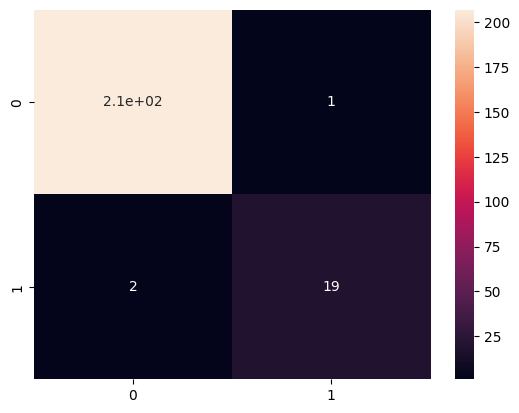

In [35]:
#run the code
import os
import time
import torch
import pickle
import numpy as np
import torch.nn.functional as F
from shutil import copyfile
from tqdm import tqdm
from torch.utils import data
from torch.optim.adadelta import Adadelta
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn import metrics

import copy
import seaborn as sns
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

torch.autograd.set_detect_anomaly(False)
#二分割できる（訓練用とテスト用）

#from pose_utils import motions_map
import sys
sys.path.append("../")
# from Actionsrecognition.Models import *

import pandas as pd
save_folder = 'saved/GSTCAN_UR_sensor'

#device = 'cuda'
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("using", device, "device")

epochs = 100
batch_size = 32 #32

# DATA FILES.
# Should be in format of
#  inputs: (N_samples, time_steps, graph_node, channels),
#  labels: (N_samples, num_class)
#   and do some of normalizations on it. Default data create from:
#       Data.create_dataset_(1-3).py
# where
#   time_steps: Number of frame input sequence, Default: 30
#   graph_node: Number of node in skeleton, Default: 14
#   channels: Inputs data (x, y and scores), Default: 3
#   num_class: Number of pose class to train, Default: 7

data_files = ['../Data/ur_fall_sensor_2cl_new-set(labelXscrw).pkl']

class_names = ['Fall','No_fall']
# num_class = len(class_names)


def accuracy_batch(y_pred, y_true):
    return (y_pred.argmax(1) == y_true.argmax(1)).mean()


def set_training(model, mode=True):
    for p in model.parameters():
        p.requires_grad = mode
    model.train(mode)
    return model


if __name__ == '__main__':
    
    #save_folder = os.path.join(os.path.dirname(), save_folder)
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    # print('Start')

    # DATA.
    train_loader, valid_loader = load_dataset_v2(data_files[0:1], batch_size,split_size=0.2) 
    
    dataloader = {'train': train_loader, 'valid': valid_loader, }
    
    #print(train_loader.shape)
    
    # MODEL.(list化)
    graph_args = {'strategy': 'spatial'}
    ## for sensor data
    # model = BiLSTM(input_size=4,hidden_size=64,num_layers=1,dropout_prob=0.3,num_classes=2,feature="mean").to(device)
    model = CNN_BiLSTM(hidden_size=16,num_layers=1,dropout_prob=0.3,num_classes=2,feature="mean").to(device)
    # model = TwoStreamSpatialTemporalGraph(graph_args, 2).to(device)
    n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"number of params: {n_parameters}")
    # model = TwoStreamSpatialTemporalGraph(graph_args, 2).to(device)
    # graph_args = {'strategy': 'uniform'}
    #graph_args = {'strategy': 'distance'}
    # print("err")
    #model = TwoStreamSpatialTemporalGraph(graph_args, num_class).to(device)
    #model = TwoStreamSpatialTemporalGraph(graph_args, 8).to(device)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
    
    
    # losser = torch.nn.BCELoss() #fall or no_fall
    losser = torch.nn.CrossEntropyLoss()

    # TRAINING.
    loss_list = {'train': [], 'valid': []}
    accu_list = {'train': [], 'valid': []}
    best_acc = -1
    for e in range(epochs):
        print('Epoch {}/{}'.format(e, epochs - 1))
        for phase in ['train', 'valid']:
            if phase == 'train':
                model = set_training(model, True)
            else:
                model = set_training(model, False)

            run_loss = 0.0
            run_accu = 0.0
            with tqdm(dataloader[phase], desc=phase) as iterator:
                for info in iterator:
                    # print(len(info))
                    pts, ser, lbs = info
                    # print(torch.any(torch.isnan(pts)))
                    # Create motion input by distance of points (x, y) of the same node
                    # in two frames.
                    #print("err")
                    mot = pts[:, :2, 1:, :] - pts[:, :2, :-1, :]
                    
                    mot = mot.to(device)
                    pts = pts.to(device)
                    ser = ser.to(device)
                    # print(ser.size())torch.Size([32, 30, 4])
                    lbs = lbs.to(device)
                    
                    #print(pts.size())torch.Size([32, 3, 30, 14])
                    #print(mot.size())torch.Size([32, 2, 29, 14])
                    
                    # Forward.
                    # out = model((pts, mot))#タプル型
                    out = model(ser) # for sensor data
                    
                    # out = stgcn_sensor_model((pts, mot,ser))
                    
                    #out = model(mot)#タプル型
                    # print(lbs)

                    # print(out)
                    loss = losser(out, lbs)
                    #print("err")
                    if phase == 'train':
                        # Backward.
                        model.zero_grad()
                        loss.backward()
                        optimizer.step()

                    run_loss += loss.item()
                    accu = accuracy_batch(out.detach().cpu().numpy(),
                                          lbs.detach().cpu().numpy())
                    run_accu += accu

                    iterator.set_postfix_str(' loss: {:.4f}, accu: {:.4f}'.format(
                        loss.item(), accu))
                    iterator.update()
                    #break
            loss_list[phase].append(run_loss / len(iterator))
            accu_list[phase].append(run_accu / len(iterator))
            #print(accu_list)
            #print(torch.max(accu_list))
        if(best_acc < accu_list['valid'][-1]):
            best_acc = accu_list['valid'][-1]
            best_model = copy.deepcopy(model)
            torch.save(model.state_dict(), os.path.join(save_folder, 'tsstg-model_best.pth'))
            #break

        print('Summary epoch:\n - Train loss: {:.4f}, accu: {:.4f}\n - Valid loss:'
        ' {:.4f}, accu: {:.4f}'.format(loss_list['train'][-1], accu_list['train'][-1],
        loss_list['valid'][-1], accu_list['valid'][-1]))
        print(best_acc)
        plt.figure()
        plt.plot(list(range(len(loss_list['train']))),loss_list['train'],label="train_loss")
        plt.plot(list(range(len(loss_list['valid']))),loss_list['valid'],label="valid_loss")
        plt.legend()
        plt.savefig(os.path.join(save_folder, f'musa-model_of_loss_report_ur.png'))
        plt.clf()
        plt.close()
        
        plt.figure()
        plt.plot(list(range(len(accu_list['train']))),accu_list['train'],label="train_acc")
        plt.plot(list(range(len(accu_list['valid']))),accu_list['valid'],label="valid_acc")
        plt.legend()
        plt.savefig(os.path.join(save_folder, f'musa-model_of_acc_report.png'))
        plt.clf()
        plt.close()
        df = pd.DataFrame([loss_list['train'],loss_list['valid']]) 
        df.to_csv(os.path.join(save_folder, f'musa-model_of_acc_report.csv'))
                  
        df = pd.DataFrame([accu_list['train'],accu_list['valid']])
        df.to_csv(os.path.join(save_folder, f'musa-model_of_accu_report.csv'))
        torch.save(best_model.state_dict(), os.path.join(save_folder, f'musa-model_of_{best_acc:.4f}_UR.pth'))

        # SAVE.
        '''
        if(best_acc < accu_list['valid'][-1]):
            best_acc = accu_list['valid'][-1]
            torch.save(model.state_dict(), os.path.join(save_folder, 'tsstg-model_best.pth'))
            '''
        '''
        plot_graphs(list(loss_list.values()), list(loss_list.keys()),
                        'Last Train: {:.2f}, Valid: {:.2f}'.format(
                            loss_list['train'][-1], loss_list['valid'][-1]
                        ), 'Loss', xlim=[0, epochs],
                        save=os.path.join(save_folder, 'loss_graph.png'))
        plot_graphs(list(accu_list.values()), list(accu_list.keys()),
                        'Last Train: {:.2f}, Valid: {:.2f}'.format(
                            accu_list['train'][-1], accu_list['valid'][-1]
                        ), 'Accu', xlim=[0, epochs],
                        save=os.path.join(save_folder, 'accu_graph.png'))
        '''
            #break

    del train_loader, valid_loader

    #model.load_state_dict(torch.load(os.path.join(save_folder, 'tsstg-model.pth',map_location=torch.device('cpu'))))
    model.load_state_dict(torch.load(os.path.join(save_folder, 'tsstg-model_best.pth')))
    # EVALUATION.
    #URのときは全部コメント
    # model = set_training(model, False)
    # data_file = data_files[1]
    # eval_loader, _ = load_dataset([data_file], 32)
    
    print('Evaluation.')
    run_loss = 0.0
    run_accu = 0.0
    y_preds = []
    y_trues = []
    model = best_model
    #with tqdm(eval_loader, desc='eval') as iterator:
    #URFD
    with tqdm(dataloader[phase], desc='eval') as iterator:
        for pts,ser, lbs in iterator:
            # print(lbs)
            mot = pts[:, :2, 1:, :] - pts[:, :2, :-1, :]
            mot = mot.to(device)
            pts = pts.to(device)
            ser = ser.to(device)
            lbs = lbs.to(device)

            # out = model((pts, mot)) # for skeleton data
            out = model(ser) # for sensor data
            #out = model(mot)################
            loss = losser(out, lbs)

            run_loss += loss.item()
            accu = accuracy_batch(out.detach().cpu().numpy(),
                                  lbs.detach().cpu().numpy())
            run_accu += accu

            y_preds.extend(out.argmax(1).detach().cpu().numpy())
            y_trues.extend(lbs.argmax(1).cpu().numpy())

            iterator.set_postfix_str('loss: {:.4f}, accu: {:.4f}'.format(
                loss.item(), accu))
            iterator.update()

    run_loss = run_loss / len(iterator)
    run_accu = run_accu / len(iterator)
    print('Eval Loss {:.4f}, Accu: {:.4f}'.format(run_loss, run_accu))
    print('Precision:', precision_score(y_trues, y_preds,average='micro'))
    print('Recall:', recall_score(y_trues, y_preds,average='micro'))
    print('F1-score:', f1_score(y_trues, y_preds,average='micro'))
    tn, fp, fn, tp = metrics.confusion_matrix(y_trues, y_preds).ravel()
    specificity  = tn / (tn + fp)
    print('Specificity:', specificity)
    print(classification_report(y_trues, y_preds,digits=5))
    report=classification_report(y_trues,  y_preds, digits=5,output_dict=True)
    report_df = pd.DataFrame(report).T
    report_df.to_csv(os.path.join(save_folder, f'musa-model_of_{run_accu:.4f}_report.csv'))

    cmx_data = confusion_matrix(y_trues, y_preds)

    df_cmx = pd.DataFrame(cmx_data)

    plt.figure()
    sns.heatmap(df_cmx, annot=True)
    plt.savefig(os.path.join(save_folder, f'musa-model_ofs_confution_matrix.png'))


In [ ]:
print(phase)Classification_Module

In [ ]:

train_loader, _ = load_dataset(data_files[0:1], batch_size) #batch_size = 32

valid_loader, train_loader_ = load_dataset(data_files[:1], batch_size, 0.2)
#print("err")
train_loader = data.DataLoader(data.ConcatDataset([train_loader.dataset, train_loader_.dataset]),
                               batch_size, shuffle=True)
dataloader = {'train': train_loader, 'valid': valid_loader}

In [ ]:
 with tqdm(dataloader[phase], desc='eval') as iterator:
        for pts, lbs in iterator:
            mot = pts[:, :2, 1:, :] - pts[:, :2, :-1, :]
            print(mot.shape)
            print(lbs)
            break


In [ ]:
import os.path

print("__file__:{}".format(os.path.dirname(__file__)))
print("dirname :{}".format(os.path.dirname(__file__)))
print("basename:{}".format(os.path.basename(__file__)))
print("files   :{}".format(os.listdir(os.path.dirname(__file__))))